# Project Overview and Introduction
## Introduction
A microbusiness is a very small-scale enterprise that typically involves only a few employees or even just one person. It's usually operated by an individual or a small team, and often focuses on providing goods or services to a local community or niche market. Microbusinesses are characterized by their simplicity, flexibility, and ability to adapt quickly to changing circumstances. They can include anything from freelancers and independent contractors to small shops and online boutiques.

This project was given as a hackathon by godaddy for microbusiness density analysis across various counties of the United States with features such as percentage of people having a broadband connection, having a college degree, foreign born, it workers and also the median household income of that county. The goal of this project is to perform time series analysis for these factors across the counties to come up with insights that will help a new store opener.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator
import seaborn as sbn
import matplotlib as mpl
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

In [3]:
train = pd.read_csv("D:\Analytics\Sigma\microBusinessDensity\\train.csv")
census = pd.read_csv("D:\Analytics\Sigma\microBusinessDensity\\census_starter.csv")

In [4]:
train.drop(["row_id"] , axis = 1, inplace=True)

In [5]:
train.head()

,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [6]:
train.first_day_of_month = pd.to_datetime(train.first_day_of_month)

In [7]:
census.head()

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


# Analysing county wise

## Merging the datasets 
For further analysis I need to merge the two datasets so the we can analyse the correlation of factors in the census dataset for microbusiness density and active number of microbusinesses respectively

In [8]:
train_pivot = train.pivot(index = "cfips", columns = "first_day_of_month")
train_pivot = train_pivot[["microbusiness_density", "active"]]
train_pivot.head()

microbusiness_density                                   \
first_day_of_month            2019-08-01 2019-09-01 2019-10-01 2019-11-01   
cfips                                                                       
1001                            3.007682   2.884870   3.055843   2.993233   
1003                            7.239156   7.290936   7.425439   7.426071   
1005                            1.073138   0.995794   1.160149   1.000628   
1007                            1.310777   1.305176   1.254761   1.254761   
1009                            1.544148   1.575892   1.546415   1.573625   

                                                                           \
first_day_of_month 2019-12-01 2020-01-01 2020-02-01 2020-03-01 2020-04-01   
cfips                                                                       
1001                 2.993233   2.969090   2.909326   2.933231   3.000167   
1003                 7.470274   7.413655   7.282522   7.309610   7.568799   
1005                 1.000628   1.027229   1.022314   1.032144   1.086209   
1007                 1.265965   1.253638   1.248041   1.264831   1.270428   
1009                 1.555485   1.573217   1.536999   1.541526   1.577744   

                               ...     active                        \
first_day_of_month 2020-05-01  ... 2022-01-01 2022-02-01 2022-03-01   
cfips                          ...                                    
1001                 3.004948  ...       1401       1417       1418   
1003                 7.603275  ...      13247      13401      13610   
1005                 1.081294  ...        235        239        237   
1007                 1.287217  ...        216        220        225   
1009                 1.575481  ...        778        789        798   

                                                                           \
first_day_of_month 2022-04-01 2022-05-01 2022-06-01 2022-07-01 2022-08-01   
cfips                                                                       
1001                     1433       1408       1422       1461       1455   
1003                    13668      13545      14573      14686      14545   
1005                      236        235        236        241        237   
1007                      223        222        227        236        230   
1009                      783        776        787        813        815   

                                          
first_day_of_month 2022-09-01 2022-10-01  
cfips                                     
1001                     1463       1472  
1003                    14289      14320  
1005                      239        244  
1007                      234        229  
1009                      822        813  

[5 rows x 78 columns]

In [9]:
train_pivot.columns = [f'{col[0]}_{col[1]}' for col in train_pivot.columns]
train_pivot.head()

,microbusiness_density_2019-08-01 00:00:00,microbusiness_density_2019-09-01 00:00:00,microbusiness_density_2019-10-01 00:00:00,microbusiness_density_2019-11-01 00:00:00,microbusiness_density_2019-12-01 00:00:00,microbusiness_density_2020-01-01 00:00:00,microbusiness_density_2020-02-01 00:00:00,microbusiness_density_2020-03-01 00:00:00,microbusiness_density_2020-04-01 00:00:00,microbusiness_density_2020-05-01 00:00:00,...,active_2022-01-01 00:00:00,active_2022-02-01 00:00:00,active_2022-03-01 00:00:00,active_2022-04-01 00:00:00,active_2022-05-01 00:00:00,active_2022-06-01 00:00:00,active_2022-07-01 00:00:00,active_2022-08-01 00:00:00,active_2022-09-01 00:00:00,active_2022-10-01 00:00:00
cfips,,,,,,,,,,,,,,,,,,,,,
1001,3.007682,2.884870,3.055843,2.993233,2.993233,2.969090,2.909326,2.933231,3.000167,3.004948,...,1401,1417,1418,1433,1408,1422,1461,1455,1463,1472
1003,7.239156,7.290936,7.425439,7.426071,7.470274,7.413655,7.282522,7.309610,7.568799,7.603275,...,13247,13401,13610,13668,13545,14573,14686,14545,14289,14320
1005,1.073138,0.995794,1.160149,1.000628,1.000628,1.027229,1.022314,1.032144,1.086209,1.081294,...,235,239,237,236,235,236,241,237,239,244
1007,1.310777,1.305176,1.254761,1.254761,1.265965,1.253638,1.248041,1.264831,1.270428,1.287217,...,216,220,225,223,222,227,236,230,234,229
1009,1.544148,1.575892,1.546415,1.573625,1.555485,1.573217,1.536999,1.541526,1.577744,1.575481,...,778,789,798,783,776,787,813,815,822,813


In [10]:
train_pivot.reset_index(inplace=True)
train_pivot.head()

,cfips,microbusiness_density_2019-08-01 00:00:00,microbusiness_density_2019-09-01 00:00:00,microbusiness_density_2019-10-01 00:00:00,microbusiness_density_2019-11-01 00:00:00,microbusiness_density_2019-12-01 00:00:00,microbusiness_density_2020-01-01 00:00:00,microbusiness_density_2020-02-01 00:00:00,microbusiness_density_2020-03-01 00:00:00,microbusiness_density_2020-04-01 00:00:00,...,active_2022-01-01 00:00:00,active_2022-02-01 00:00:00,active_2022-03-01 00:00:00,active_2022-04-01 00:00:00,active_2022-05-01 00:00:00,active_2022-06-01 00:00:00,active_2022-07-01 00:00:00,active_2022-08-01 00:00:00,active_2022-09-01 00:00:00,active_2022-10-01 00:00:00
0,1001,3.007682,2.884870,3.055843,2.993233,2.993233,2.969090,2.909326,2.933231,3.000167,...,1401,1417,1418,1433,1408,1422,1461,1455,1463,1472
1,1003,7.239156,7.290936,7.425439,7.426071,7.470274,7.413655,7.282522,7.309610,7.568799,...,13247,13401,13610,13668,13545,14573,14686,14545,14289,14320
2,1005,1.073138,0.995794,1.160149,1.000628,1.000628,1.027229,1.022314,1.032144,1.086209,...,235,239,237,236,235,236,241,237,239,244
3,1007,1.310777,1.305176,1.254761,1.254761,1.265965,1.253638,1.248041,1.264831,1.270428,...,216,220,225,223,222,227,236,230,234,229
4,1009,1.544148,1.575892,1.546415,1.573625,1.555485,1.573217,1.536999,1.541526,1.577744,...,778,789,798,783,776,787,813,815,822,813


In [11]:
# Merging census and train_pivot
df = pd.merge(train_pivot, census, on="cfips", how="left")
df.head()

,cfips,microbusiness_density_2019-08-01 00:00:00,microbusiness_density_2019-09-01 00:00:00,microbusiness_density_2019-10-01 00:00:00,microbusiness_density_2019-11-01 00:00:00,microbusiness_density_2019-12-01 00:00:00,microbusiness_density_2020-01-01 00:00:00,microbusiness_density_2020-02-01 00:00:00,microbusiness_density_2020-03-01 00:00:00,microbusiness_density_2020-04-01 00:00:00,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,1001,3.007682,2.884870,3.055843,2.993233,2.993233,2.969090,2.909326,2.933231,3.000167,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,1003,7.239156,7.290936,7.425439,7.426071,7.470274,7.413655,7.282522,7.309610,7.568799,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,1005,1.073138,0.995794,1.160149,1.000628,1.000628,1.027229,1.022314,1.032144,1.086209,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,1007,1.310777,1.305176,1.254761,1.254761,1.265965,1.253638,1.248041,1.264831,1.270428,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,1009,1.544148,1.575892,1.546415,1.573625,1.555485,1.573217,1.536999,1.541526,1.577744,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


Making a dataset having cfip and there county names and state names respectively

In [12]:
df_county = train[["cfips", "county", "state"]].drop_duplicates()
df_county.shape

(3135, 3)

In [13]:
df = pd.merge(df, df_county, on="cfips", how="left")
df.head()

,cfips,microbusiness_density_2019-08-01 00:00:00,microbusiness_density_2019-09-01 00:00:00,microbusiness_density_2019-10-01 00:00:00,microbusiness_density_2019-11-01 00:00:00,microbusiness_density_2019-12-01 00:00:00,microbusiness_density_2020-01-01 00:00:00,microbusiness_density_2020-02-01 00:00:00,microbusiness_density_2020-03-01 00:00:00,microbusiness_density_2020-04-01 00:00:00,...,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,county,state
0,1001,3.007682,2.884870,3.055843,2.993233,2.993233,2.969090,2.909326,2.933231,3.000167,...,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0,Autauga County,Alabama
1,1003,7.239156,7.290936,7.425439,7.426071,7.470274,7.413655,7.282522,7.309610,7.568799,...,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0,Baldwin County,Alabama
2,1005,1.073138,0.995794,1.160149,1.000628,1.000628,1.027229,1.022314,1.032144,1.086209,...,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0,Barbour County,Alabama
3,1007,1.310777,1.305176,1.254761,1.254761,1.265965,1.253638,1.248041,1.264831,1.270428,...,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0,Bibb County,Alabama
4,1009,1.544148,1.575892,1.546415,1.573625,1.555485,1.573217,1.536999,1.541526,1.577744,...,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0,Blount County,Alabama


Now we can start analysing this dataset


In [14]:
census.columns

Index(['pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020',
       'pct_bb_2021', 'cfips', 'pct_college_2017', 'pct_college_2018',
       'pct_college_2019', 'pct_college_2020', 'pct_college_2021',
       'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021'],
      dtype='object')

In [15]:
# Time series analysis for a particular county for percentage of population having broadband, it job, foreign birth, college degree and analysis for median household income
countyNumber = 1009
county_df = df[df["cfips"] == countyNumber]
time_factors = pd.DataFrame(range(2017, 2022)).values.flatten()
series_bb = county_df[county_df.columns[county_df.columns.str.startswith("pct_bb")]].values.flatten()
series_college = county_df[county_df.columns[county_df.columns.str.startswith("pct_college")]].values.flatten()
series_foreign_born = county_df[county_df.columns[county_df.columns.str.startswith("pct_foreign_born")]].values.flatten()
series_it_workers = county_df[county_df.columns[county_df.columns.str.startswith("pct_it_workers")]].values.flatten()
series_median_hh_inc = county_df[county_df.columns[county_df.columns.str.startswith("median_hh_inc")]].values.flatten()

In [16]:
def plot_series_df(time, series, label=None):
    plt.figure(figsize=(10, 6))
    plt.plot(time, series)  # Casting time values to integers
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14, labels=label)
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Forcing integer tick labels on x-axis
    plt.show()

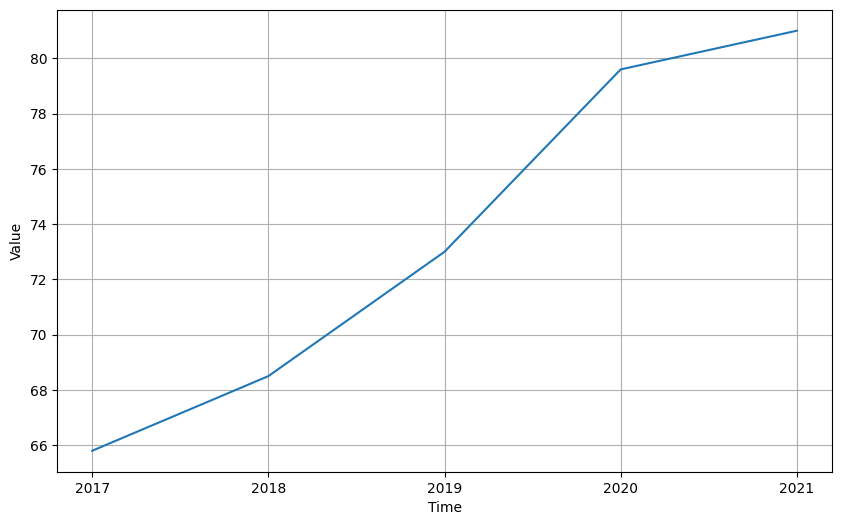

In [17]:
plot_series_df(time_factors, series_bb)

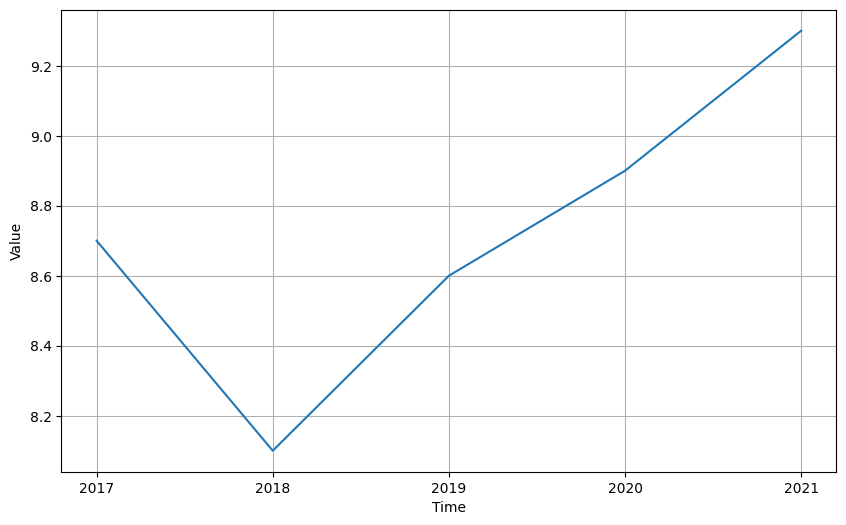

In [18]:
plot_series_df(time_factors, series_college)

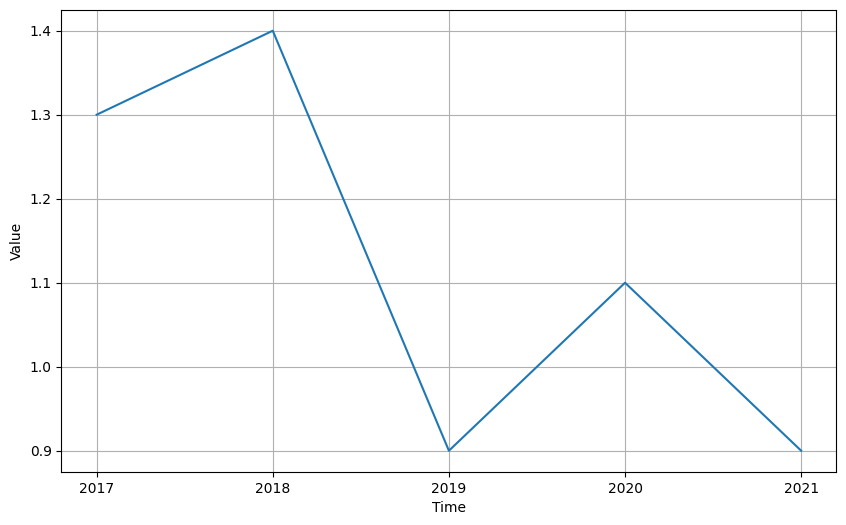

In [19]:
plot_series_df(time_factors, series_it_workers)

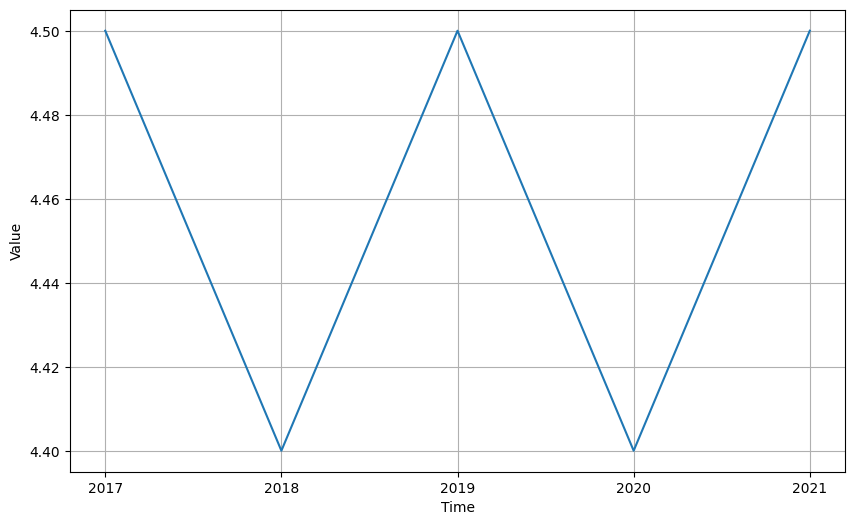

In [20]:
plot_series_df(time_factors, series_foreign_born)

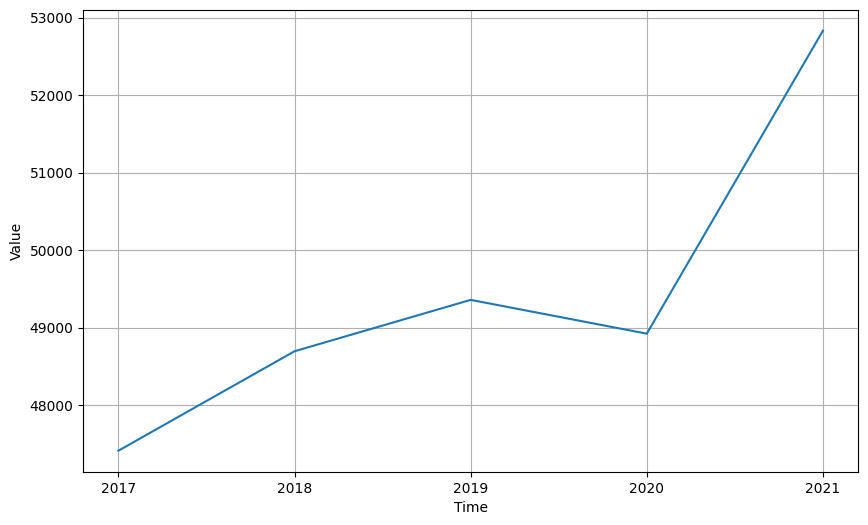

In [21]:
plot_series_df(time_factors, series_median_hh_inc)

Microbusiness and no of active businesses time series 

In [22]:
countyNumber = 1009
county_df = df[df["cfips"] == countyNumber]
time_mb = train["first_day_of_month"].unique()
time_mb = pd.to_datetime(time_mb)
series_mdb = county_df[county_df.columns[county_df.columns.str.startswith("microbusiness_density")]].values.flatten()
series_active = county_df[county_df.columns[county_df.columns.str.startswith("active")]].values.flatten()

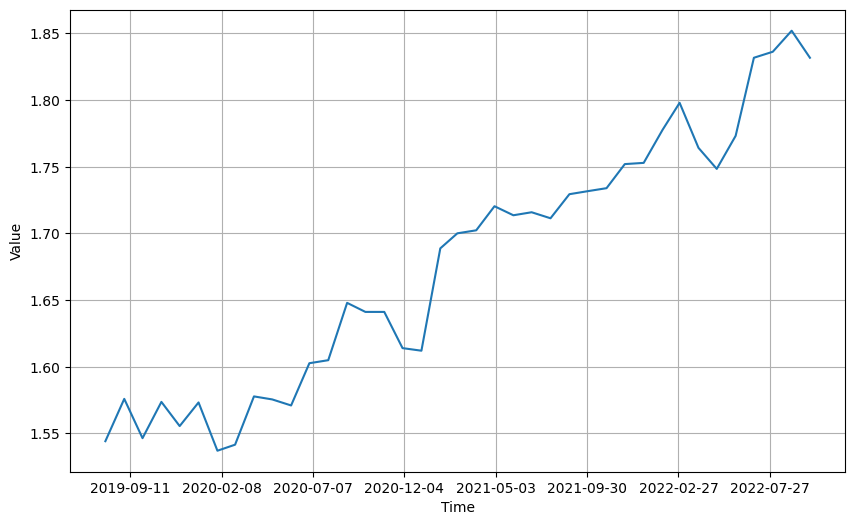

In [24]:
plot_series_df(time_mb, series_mdb)

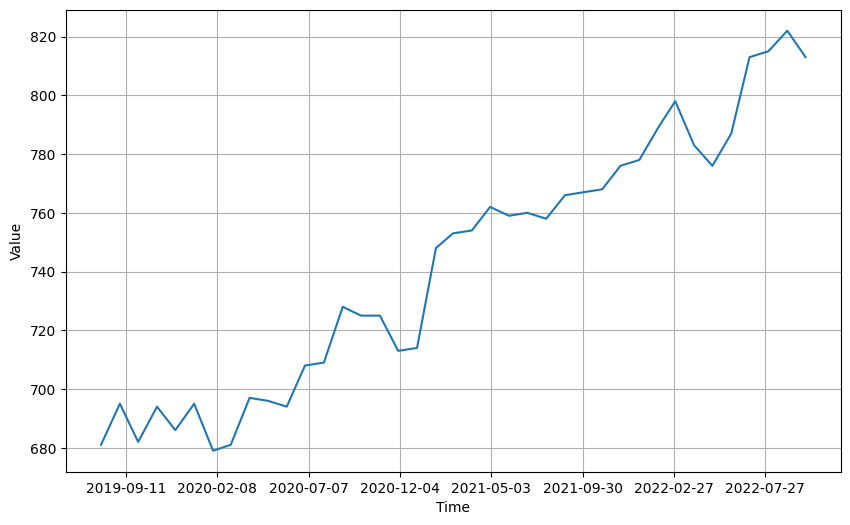

In [25]:
plot_series_df(time_mb, series_active)

# Statistical Analysis

### Descriptive Statistics for all factors

### Correlation analysis in time series
1. Dynamic Time Warping (DTW) -https://www.theaidream.com/post/dynamic-time-warping-dtw-algorithm-in-time-series#:~:text=In%20time%20series%20analysis%2C%20Dynamic,similar%20elements%20between%20time%20series.

In [26]:
# First we need to scale our time series to make sure that correlation isn't affected by scale and magnitude
def MaxScaler(series):
    maxm = max(series)
    series = [x/maxm for x in series]
    return series
    

In [27]:
series_mdb_scaled = MaxScaler(series_mdb)
series_bb_scaled = MaxScaler(series_bb)
series_college_scaled = MaxScaler(series_college)
series_active_scaled = MaxScaler(series_active)
series_foreign_born_scaled = MaxScaler(series_foreign_born)
series_it_workers_scaled = MaxScaler(series_it_workers)
series_median_hh_inc_scaled = MaxScaler(series_median_hh_inc)

In [28]:
mpl.rcParams['figure.dpi'] = 150
savefig_options = dict(format="png", dpi=150, bbox_inches="tight")

In [29]:
# Computation of euclidean distance

def compute_euclidean_distance_matrix(x, y) -> np.array:
    dist = np.zeros((len(y), len(x)))
    for i in range(len(y)):
        for j in range(len(x)):
            dist[i,j] = (x[j]-y[i])**2
    return dist

In [30]:
# Computing accumulated cost matrix for warp path using Euclidean distance

def compute_accumulated_cost_matrix(x, y) -> np.array:    
    distances = compute_euclidean_distance_matrix(x, y)
    cost = np.zeros((len(y), len(x)))
    cost[0,0] = distances[0,0]
    
    for i in range(1, len(y)):
        cost[i, 0] = distances[i, 0] + cost[i-1, 0]  
        
    for j in range(1, len(x)):
        cost[0, j] = distances[0, j] + cost[0, j-1]  

    for i in range(1, len(y)):
        for j in range(1, len(x)):
            cost[i, j] = min(
                cost[i-1, j],    
                cost[i, j-1],    
                cost[i-1, j-1]   
            ) + distances[i, j] 
            
    return cost

Text(0.5, 1.0, 'Euclidean Distance')

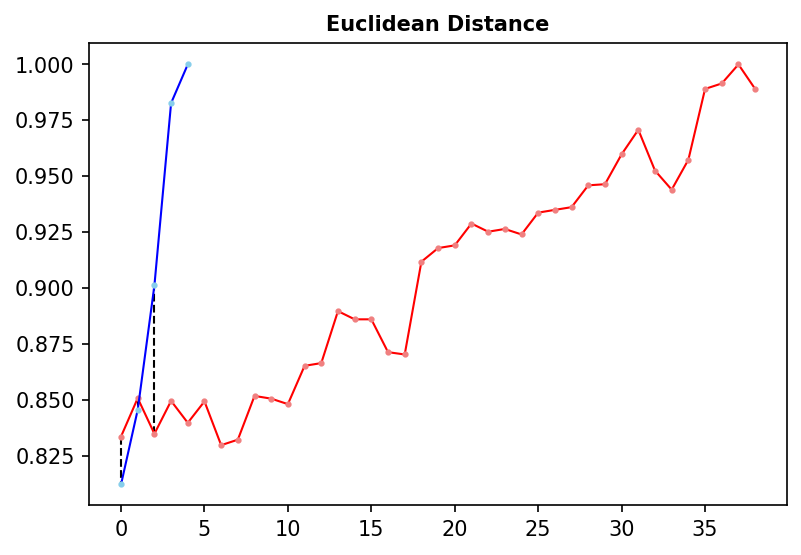

In [35]:
# Correlation between mdb and series_bb
x = np.array(series_mdb_scaled)
y = np.array(series_bb_scaled)

fig, ax = plt.subplots(figsize=(6, 4))

xx = [(i, x[i]) for i in np.arange(0, len(x))]
yy = [(j, y[j]) for j in np.arange(0, len(y))]

for i, j in zip(xx, yy[:-2]):
    ax.plot([i[0], j[0]], [i[1], j[1]], '--k', linewidth=1)

ax.plot(x, '-ro', label='x', linewidth=1, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
ax.plot(y, '-bo', label='y', linewidth=1, markersize=2, markerfacecolor='skyblue', markeredgecolor='skyblue')
ax.set_title("Euclidean Distance", fontsize=10, fontweight="bold")

In [ ]:
x = series_mdb_scaled
y = series_bb_scaled
x = pd.DataFrame(x)
y = pd.DataFrame(y)
dtw_distance, warp_path = fastdtw(x, y, dist=euclidean)

In [ ]:
x = series_mdb_scaled
y = series_bb_scaled
cost_matrix = compute_accumulated_cost_matrix(x, y)

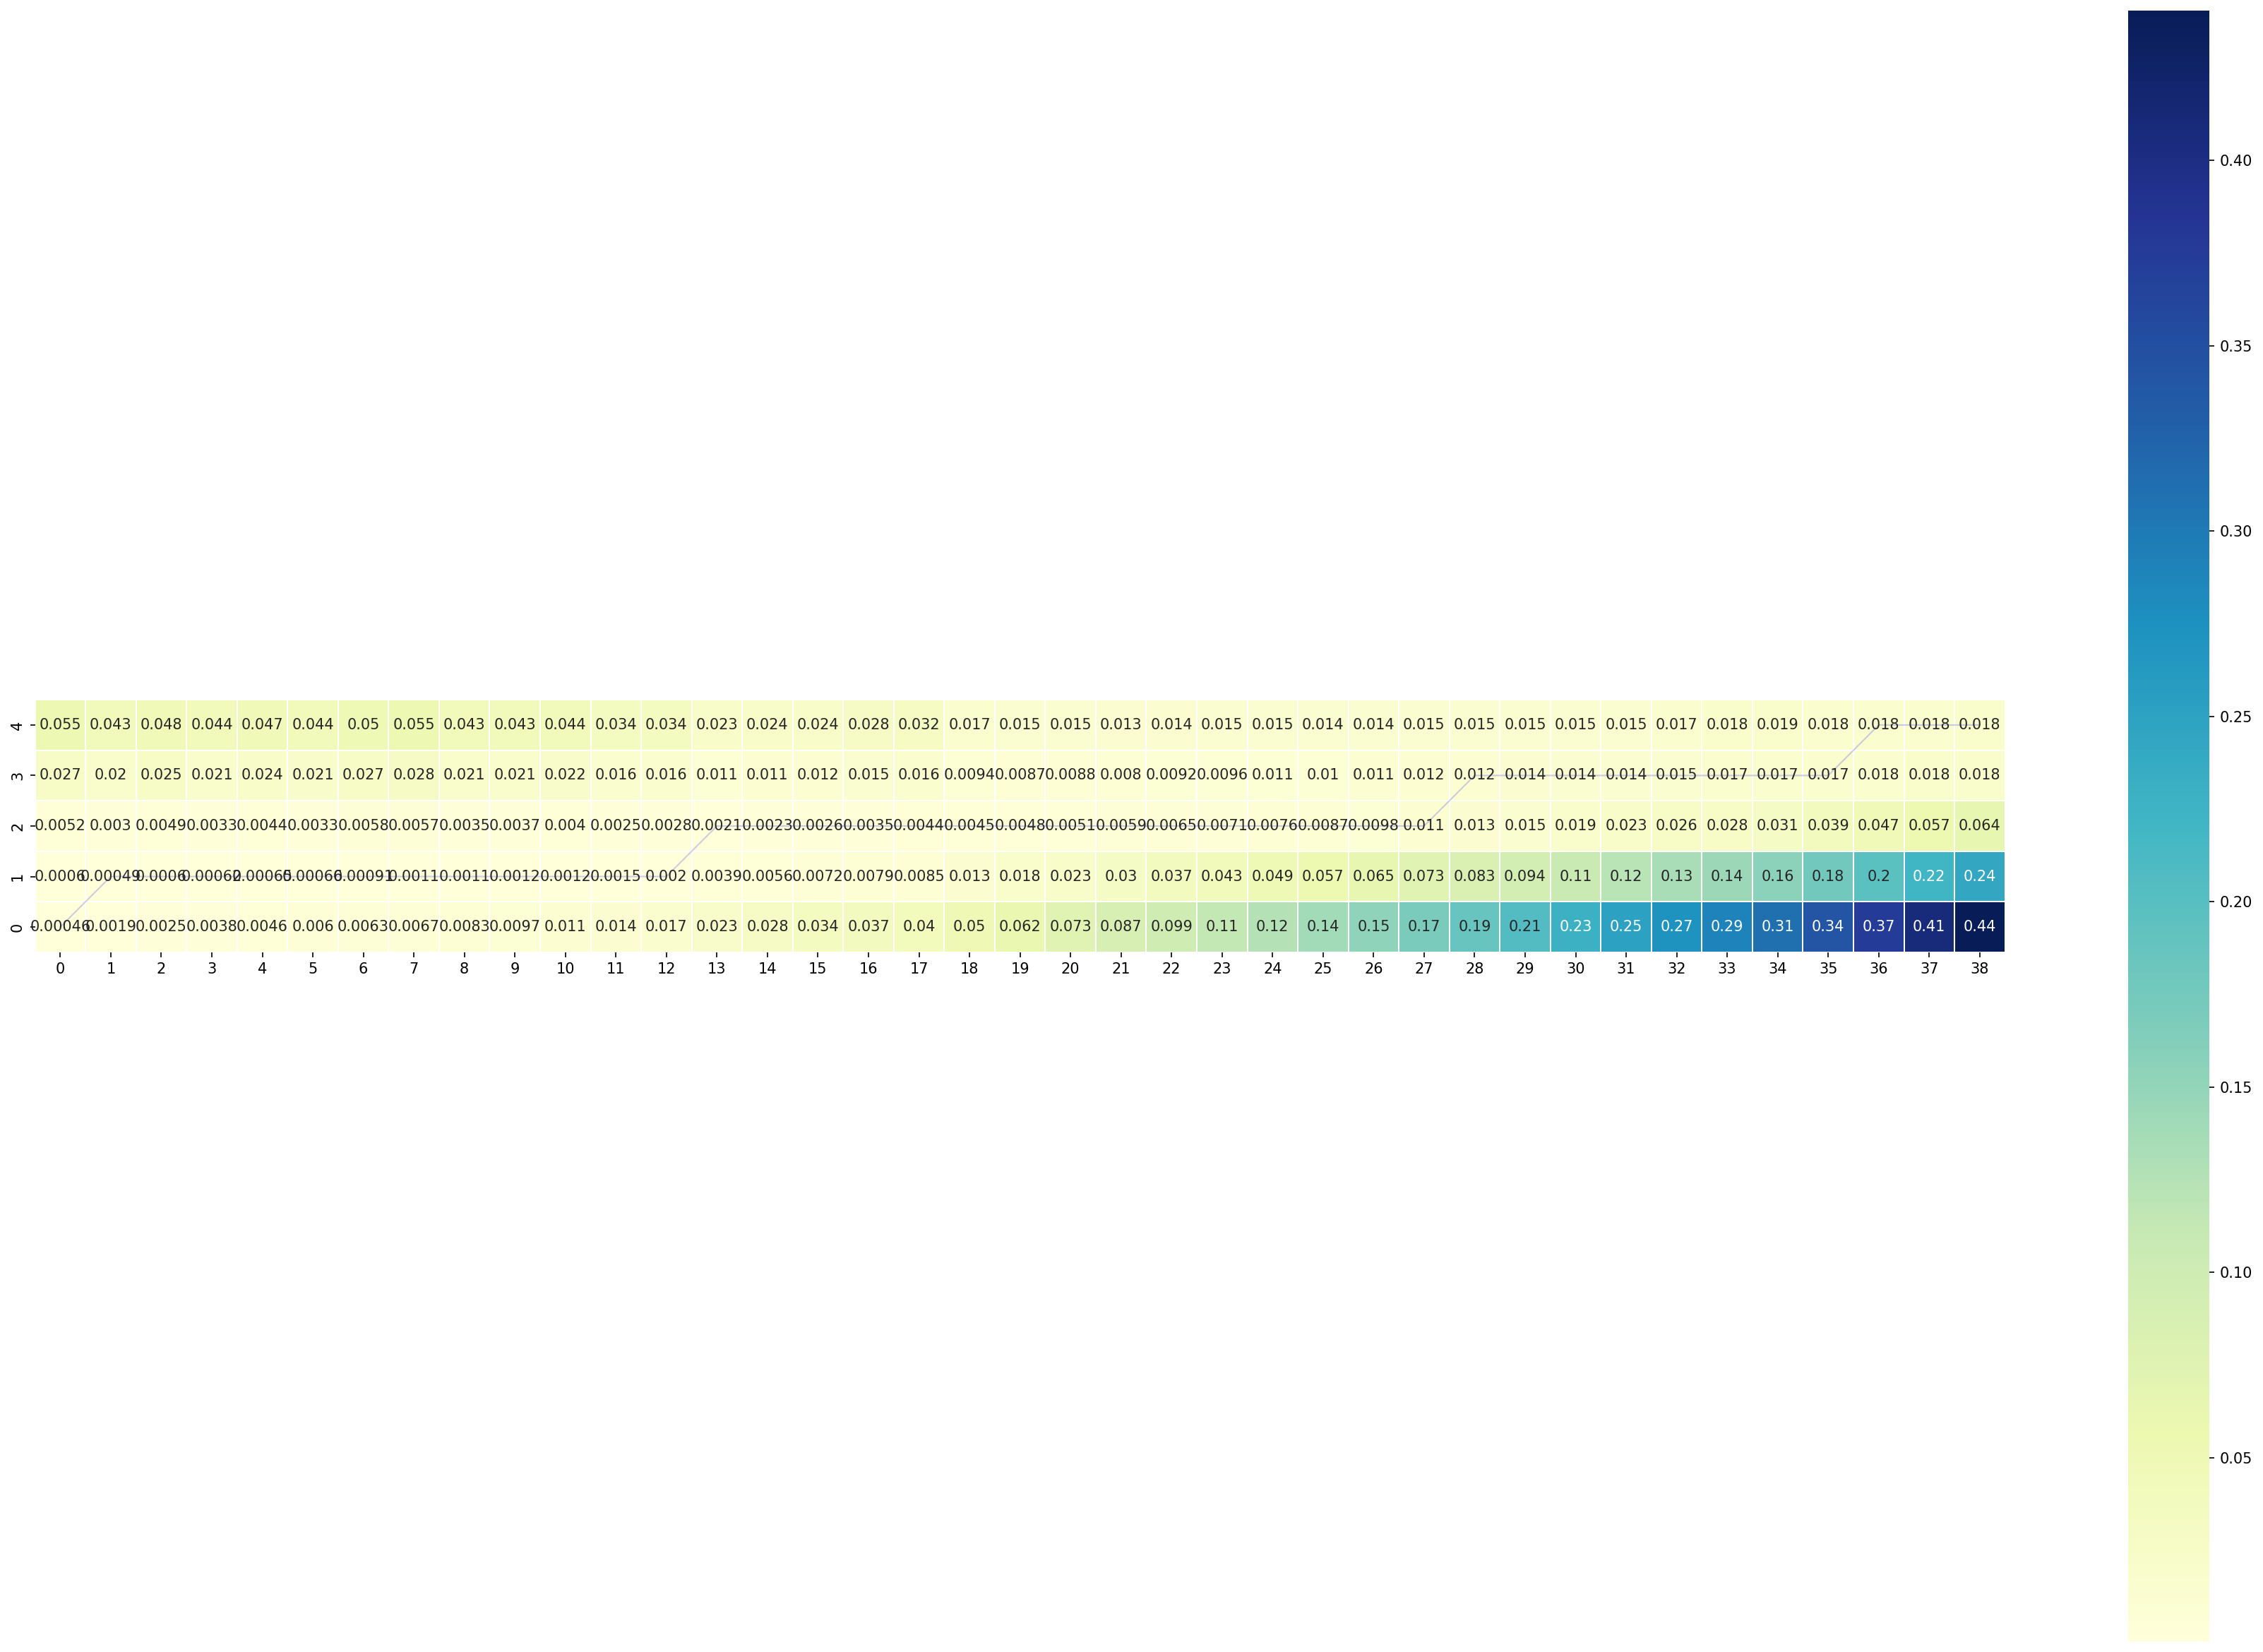

In [ ]:
fig, ax = plt.subplots(figsize=(30, 20))
ax = sbn.heatmap(cost_matrix, annot=True, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)
ax.invert_yaxis()

# Get the warp path in x and y directions
path_x = [p[0] for p in warp_path]
path_y = [p[1] for p in warp_path]

# Align the path from the center of each cell
path_xx = [x+0.5 for x in path_x]
path_yy = [y+0.5 for y in path_y]

ax.plot(path_xx, path_yy, color='blue', linewidth=1, alpha=0.2)

In [ ]:
print("DTW distance: ", dtw_distance)
print("Warp path: ", warp_path)

DTW distance:  0.7106011784043593
Warp path:  [(0, 0), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 2), (15, 2), (16, 2), (17, 2), (18, 2), (19, 2), (20, 2), (21, 2), (22, 2), (23, 2), (24, 2), (25, 2), (26, 2), (27, 2), (28, 3), (29, 3), (30, 3), (31, 3), (32, 3), (33, 3), (34, 3), (35, 3), (36, 4), (37, 4), (38, 4)]


Text(0.5, 1.0, 'Euclidean Distance')

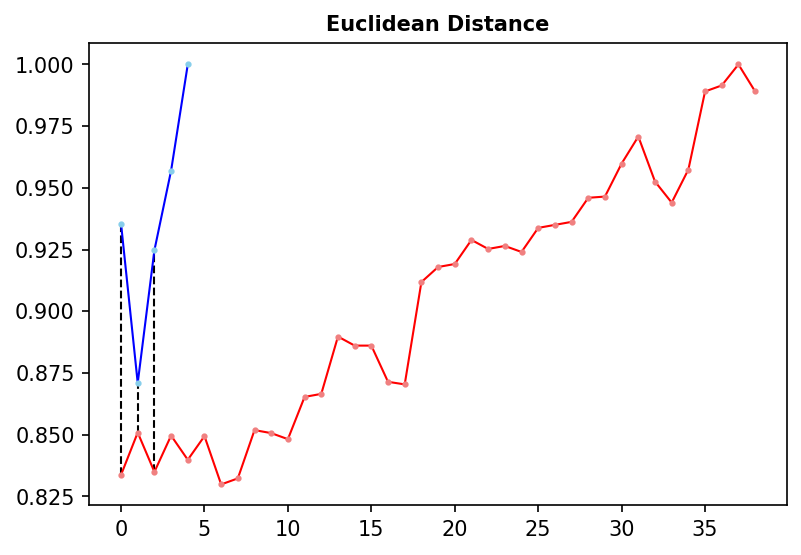

In [34]:
# Correlation between mdb and series_college
x = np.array(series_mdb_scaled)
y = np.array(series_college_scaled)

fig, ax = plt.subplots(figsize=(6, 4))

xx = [(i, x[i]) for i in np.arange(0, len(x))]
yy = [(j, y[j]) for j in np.arange(0, len(y))]

for i, j in zip(xx, yy[:-2]):
    ax.plot([i[0], j[0]], [i[1], j[1]], '--k', linewidth=1)

ax.plot(x, '-ro', label='x', linewidth=1, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
ax.plot(y, '-bo', label='y', linewidth=1, markersize=2, markerfacecolor='skyblue', markeredgecolor='skyblue')
ax.set_title("Euclidean Distance", fontsize=10, fontweight="bold")

In [36]:
x = series_mdb_scaled
y = series_college_scaled
x = pd.DataFrame(x)
y = pd.DataFrame(y)
dtw_distance, warp_path = fastdtw(x, y, dist=euclidean)
x = series_mdb_scaled
y = series_bb_scaled
cost_matrix = compute_accumulated_cost_matrix(x, y)

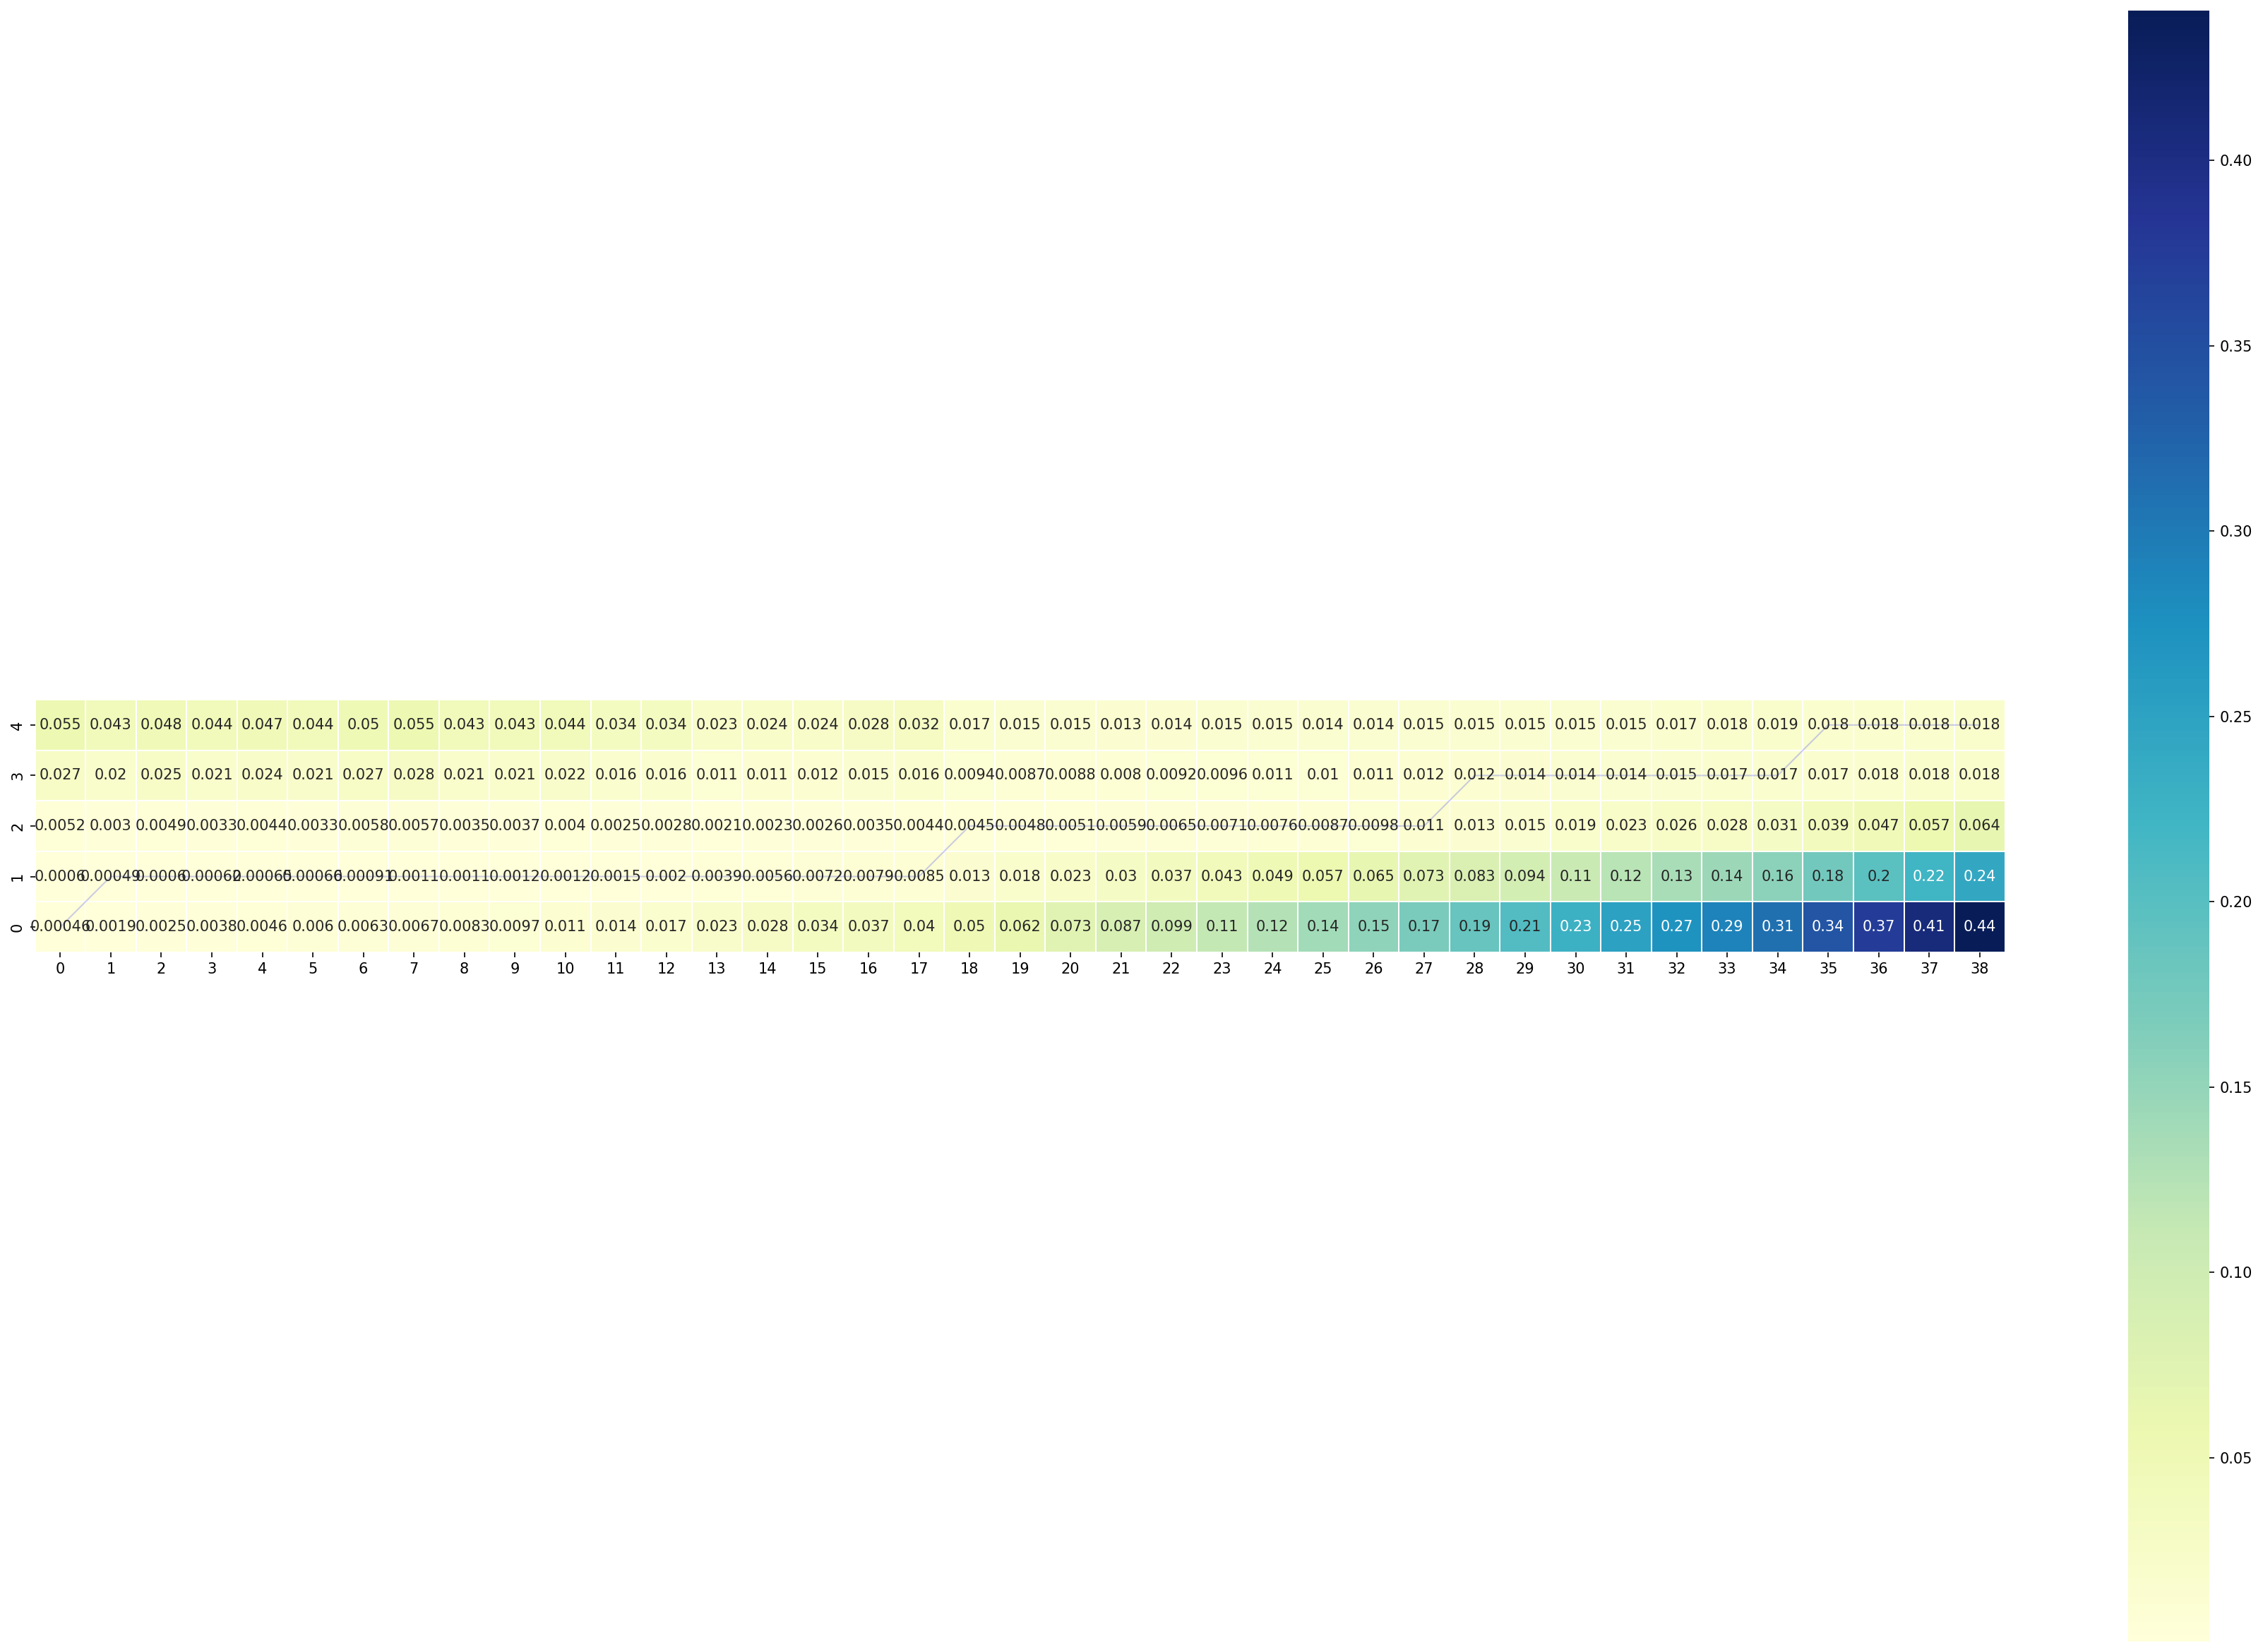

In [37]:
fig, ax = plt.subplots(figsize=(30, 20))
ax = sbn.heatmap(cost_matrix, annot=True, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)
ax.invert_yaxis()

# Get the warp path in x and y directions
path_x = [p[0] for p in warp_path]
path_y = [p[1] for p in warp_path]

# Align the path from the center of each cell
path_xx = [x+0.5 for x in path_x]
path_yy = [y+0.5 for y in path_y]

ax.plot(path_xx, path_yy, color='blue', linewidth=1, alpha=0.2)

In [38]:
print("DTW distance: ", dtw_distance)
print("Warp path: ", warp_path)

DTW distance:  0.5834422530027186
Warp path:  [(0, 0), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 2), (20, 2), (21, 2), (22, 2), (23, 2), (24, 2), (25, 2), (26, 2), (27, 2), (28, 3), (29, 3), (30, 3), (31, 3), (32, 3), (33, 3), (34, 3), (35, 4), (36, 4), (37, 4), (38, 4)]


Text(0.5, 1.0, 'Euclidean Distance')

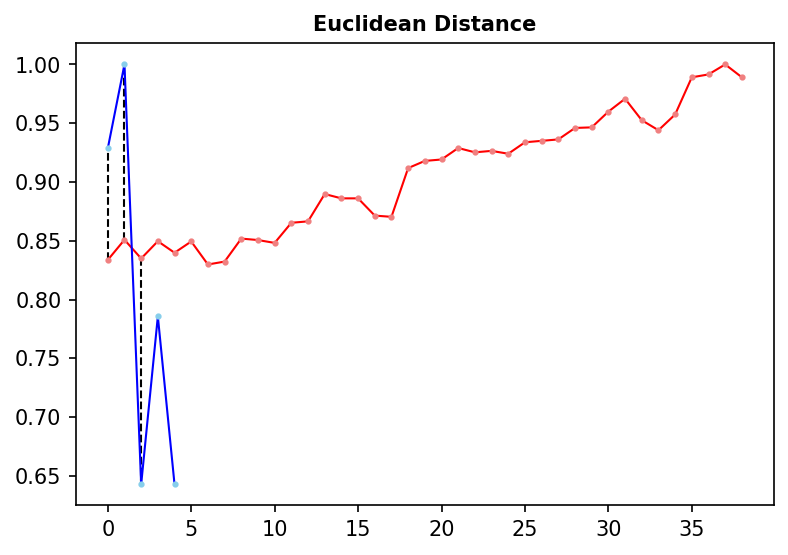

In [42]:
# Correlation between mdb and series_it_workers
x = np.array(series_mdb_scaled)
y = np.array(series_it_workers_scaled)

fig, ax = plt.subplots(figsize=(6, 4))

xx = [(i, x[i]) for i in np.arange(0, len(x))]
yy = [(j, y[j]) for j in np.arange(0, len(y))]

for i, j in zip(xx, yy[:-2]):
    ax.plot([i[0], j[0]], [i[1], j[1]], '--k', linewidth=1)

ax.plot(x, '-ro', label='x', linewidth=1, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
ax.plot(y, '-bo', label='y', linewidth=1, markersize=2, markerfacecolor='skyblue', markeredgecolor='skyblue')
ax.set_title("Euclidean Distance", fontsize=10, fontweight="bold")

In [43]:
x = series_mdb_scaled
y = series_it_workers_scaled
x = pd.DataFrame(x)
y = pd.DataFrame(y)
dtw_distance, warp_path = fastdtw(x, y, dist=euclidean)
x = series_mdb_scaled
y = series_bb_scaled
cost_matrix = compute_accumulated_cost_matrix(x, y)

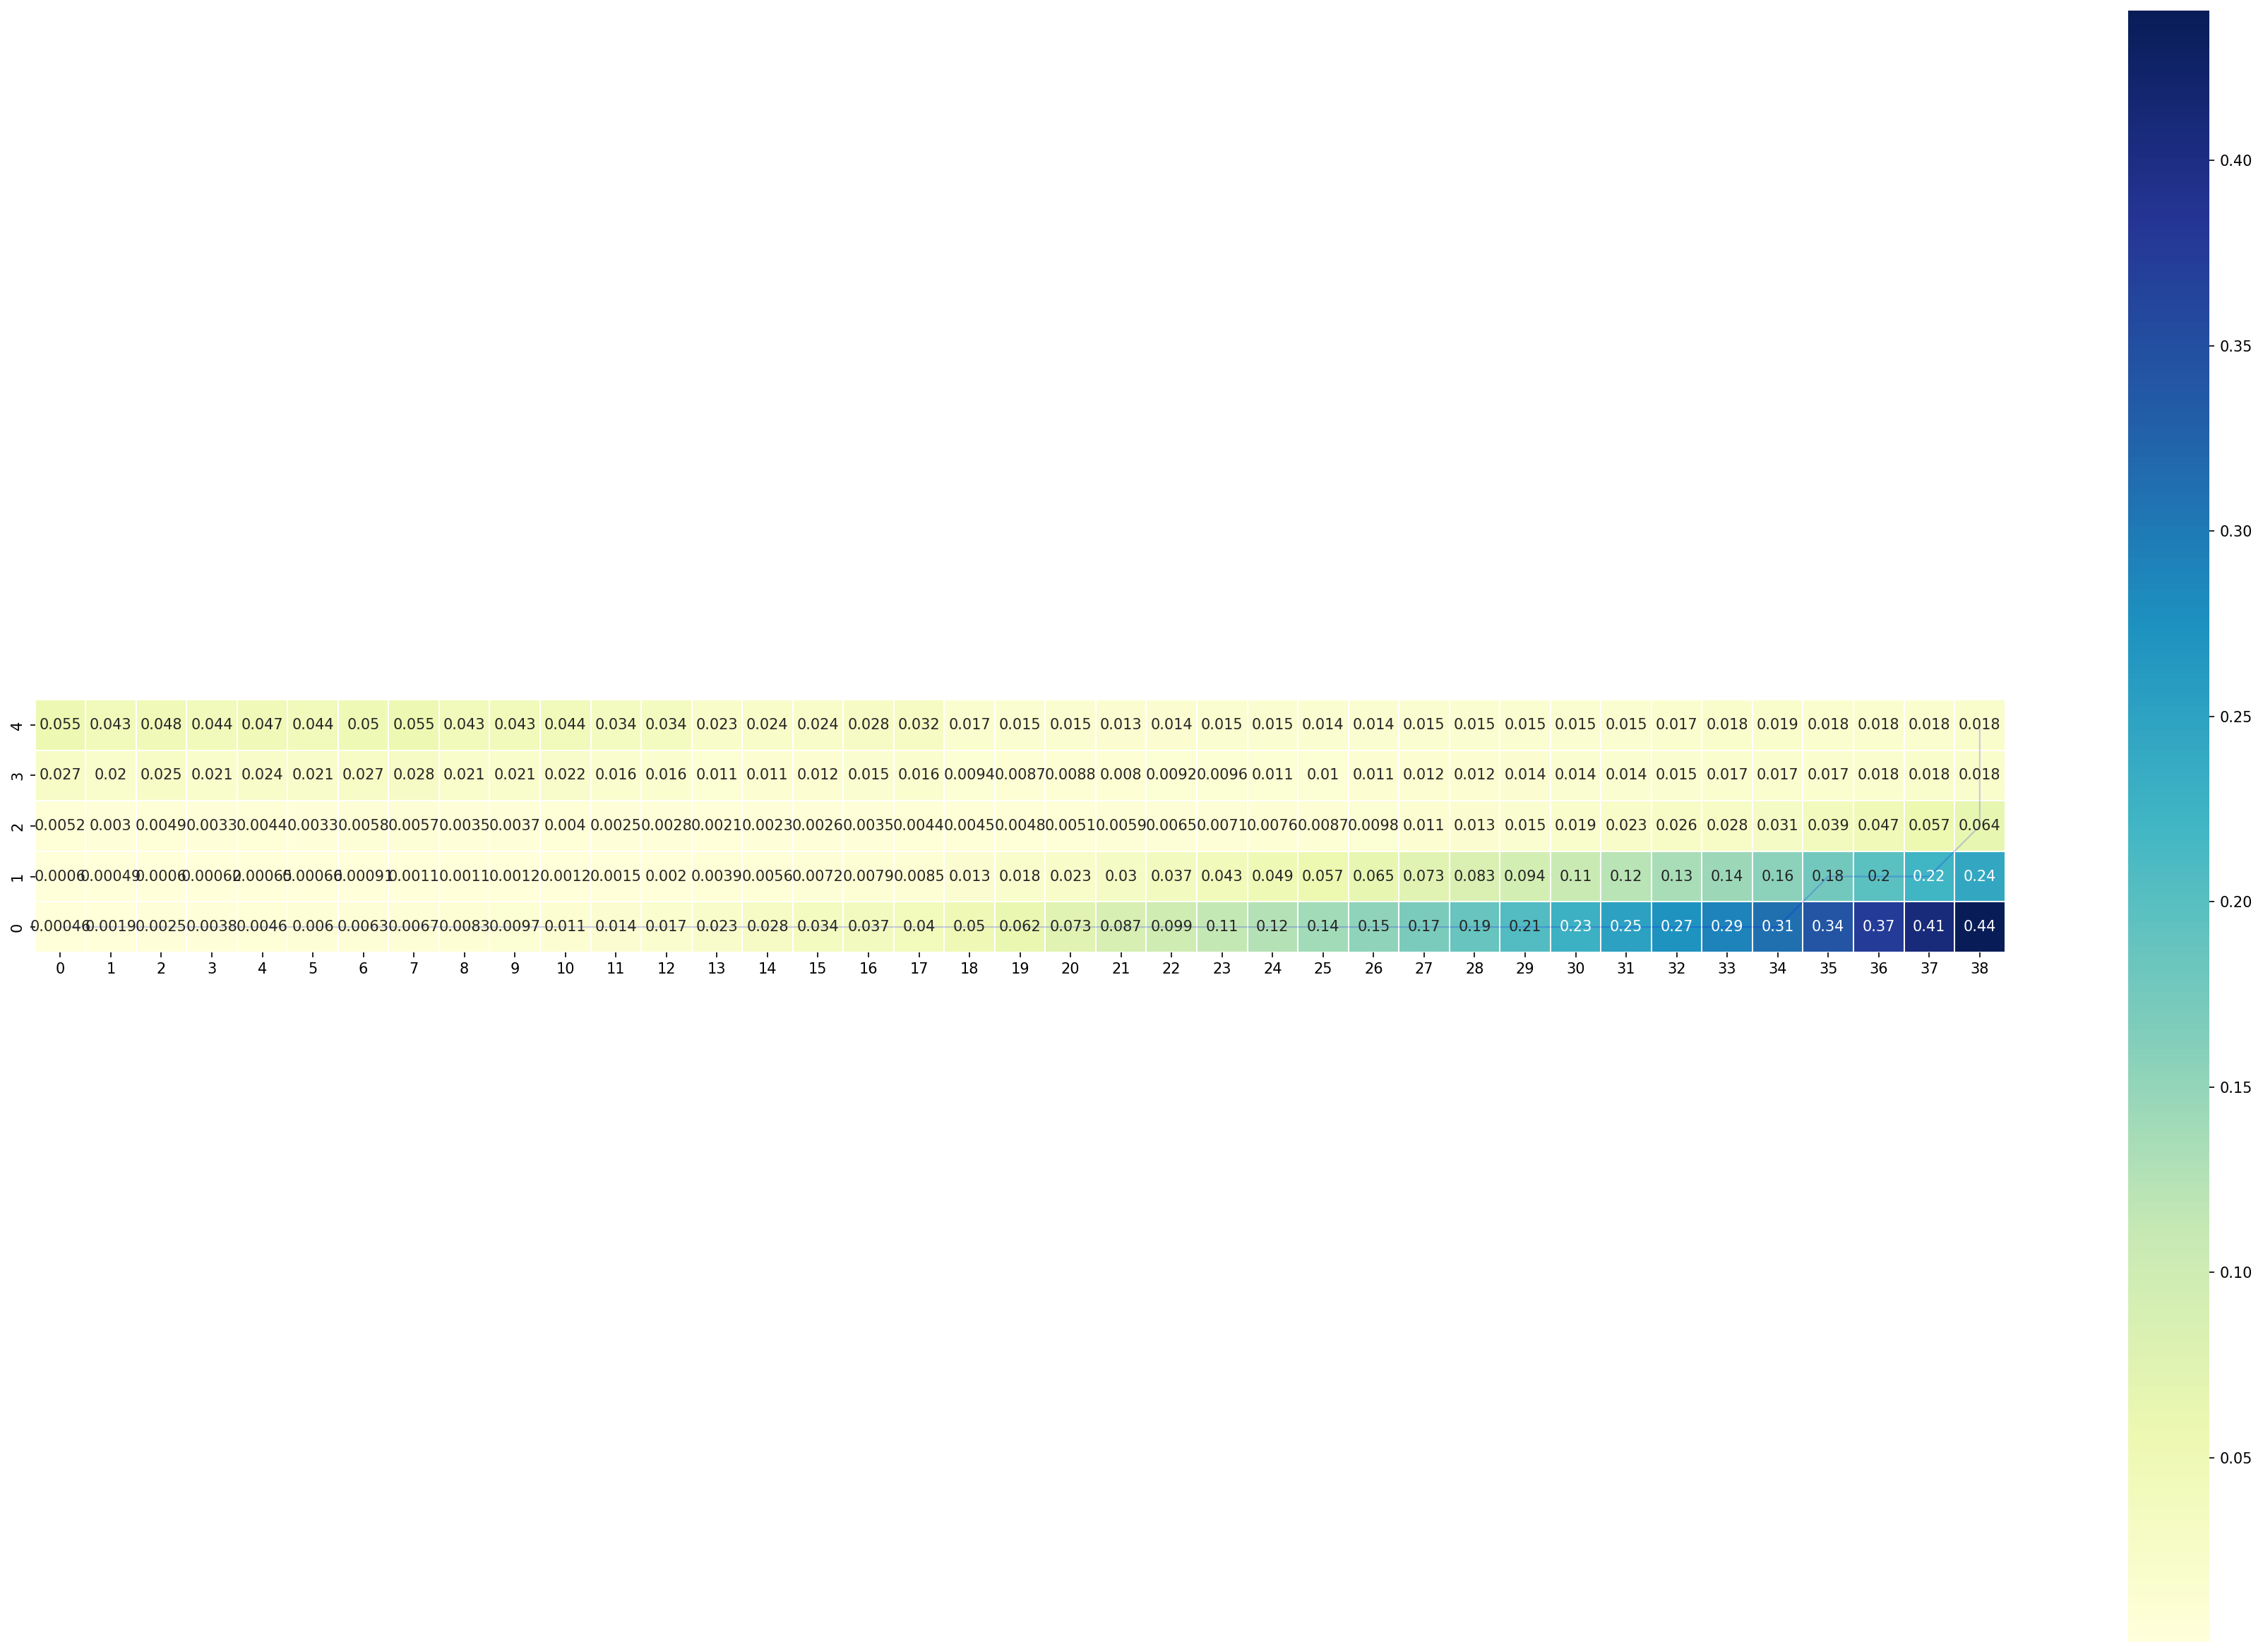

In [44]:
fig, ax = plt.subplots(figsize=(30, 20))
ax = sbn.heatmap(cost_matrix, annot=True, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)
ax.invert_yaxis()

# Get the warp path in x and y directions
path_x = [p[0] for p in warp_path]
path_y = [p[1] for p in warp_path]

# Align the path from the center of each cell
path_xx = [x+0.5 for x in path_x]
path_yy = [y+0.5 for y in path_y]

ax.plot(path_xx, path_yy, color='blue', linewidth=1, alpha=0.2)

In [45]:
print("DTW distance: ", dtw_distance)
print("Warp path: ", warp_path)

DTW distance:  2.4656942073811425
Warp path:  [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (33, 0), (34, 0), (35, 1), (36, 1), (37, 1), (38, 2), (38, 3), (38, 4)]


Text(0.5, 1.0, 'Euclidean Distance')

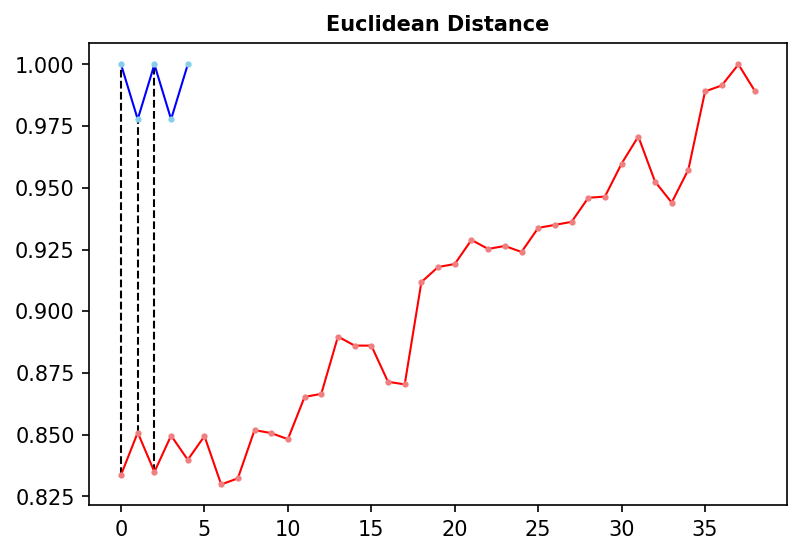

In [46]:
# Correlation between mdb and series_it_workers
x = np.array(series_mdb_scaled)
y = np.array(series_foreign_born_scaled)

fig, ax = plt.subplots(figsize=(6, 4))

xx = [(i, x[i]) for i in np.arange(0, len(x))]
yy = [(j, y[j]) for j in np.arange(0, len(y))]

for i, j in zip(xx, yy[:-2]):
    ax.plot([i[0], j[0]], [i[1], j[1]], '--k', linewidth=1)

ax.plot(x, '-ro', label='x', linewidth=1, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
ax.plot(y, '-bo', label='y', linewidth=1, markersize=2, markerfacecolor='skyblue', markeredgecolor='skyblue')
ax.set_title("Euclidean Distance", fontsize=10, fontweight="bold")

In [47]:
x = series_mdb_scaled
y = series_foreign_born_scaled
x = pd.DataFrame(x)
y = pd.DataFrame(y)
dtw_distance, warp_path = fastdtw(x, y, dist=euclidean)
x = series_mdb_scaled
y = series_bb_scaled
cost_matrix = compute_accumulated_cost_matrix(x, y)

DTW distance:  2.937013486889164
Warp path:  [(0, 0), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 3), (37, 4), (38, 4)]


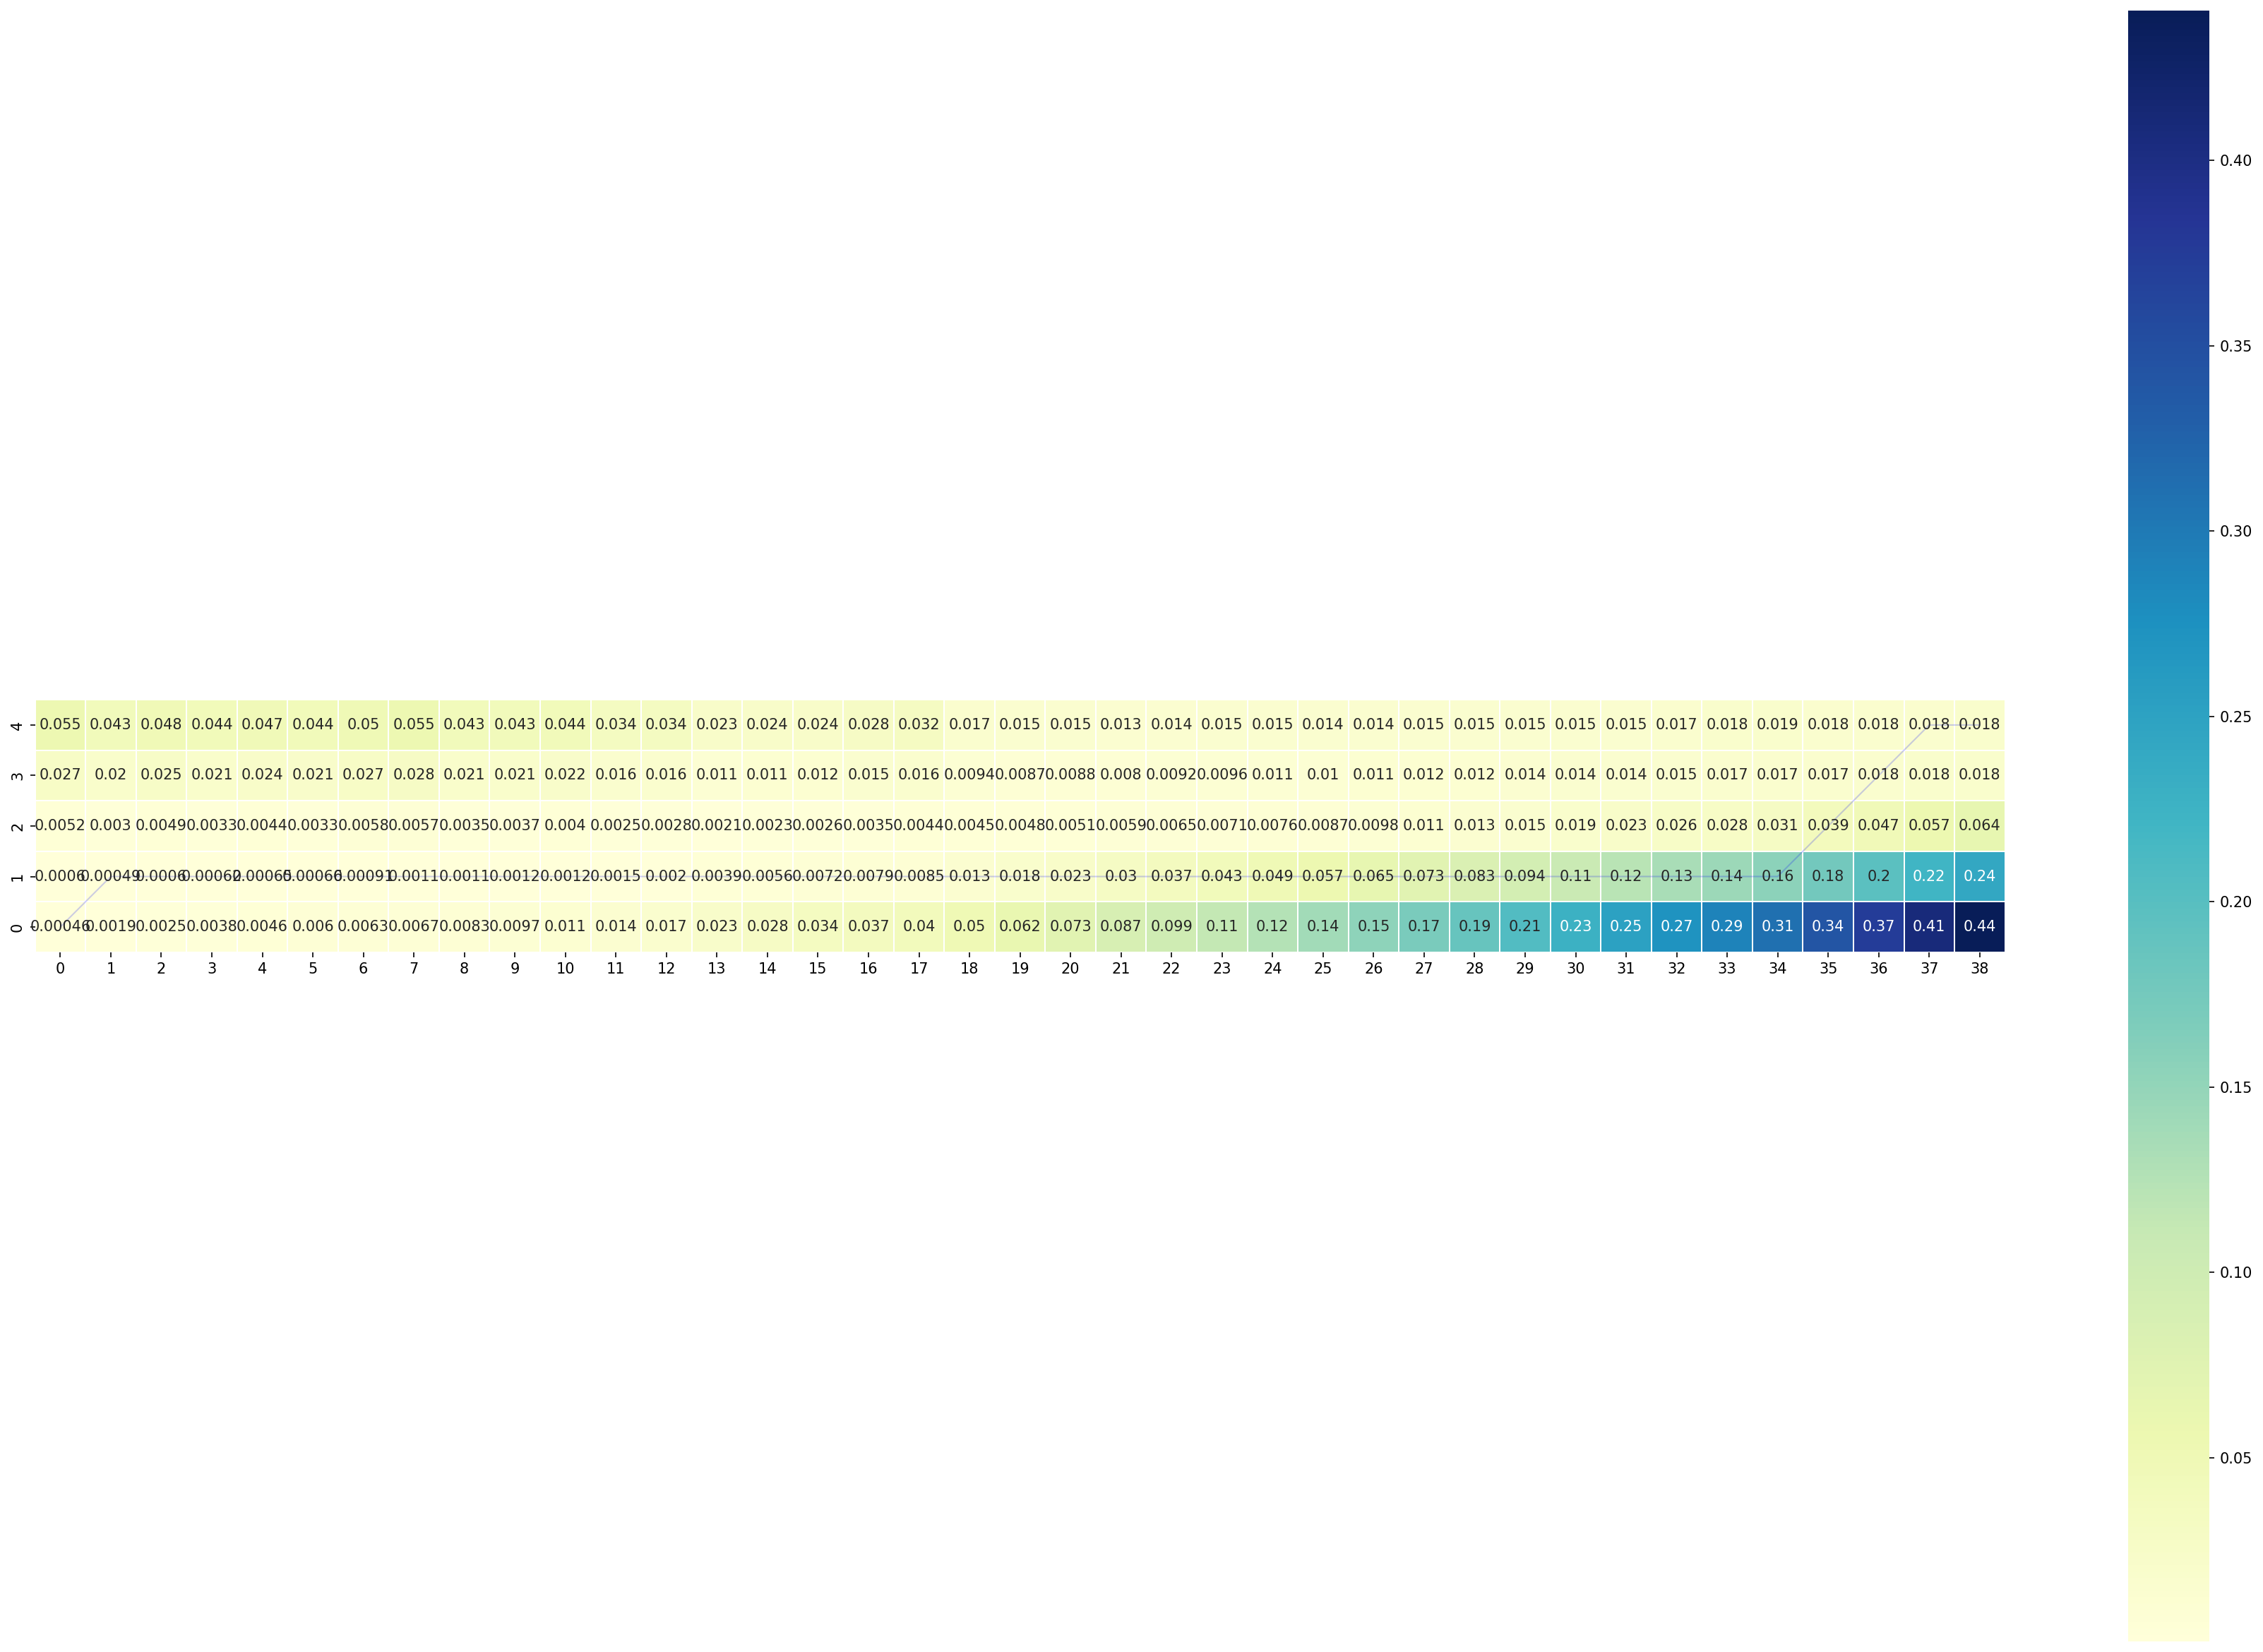

In [48]:
fig, ax = plt.subplots(figsize=(30, 20))
ax = sbn.heatmap(cost_matrix, annot=True, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)
ax.invert_yaxis()

# Get the warp path in x and y directions
path_x = [p[0] for p in warp_path]
path_y = [p[1] for p in warp_path]

# Align the path from the center of each cell
path_xx = [x+0.5 for x in path_x]
path_yy = [y+0.5 for y in path_y]

ax.plot(path_xx, path_yy, color='blue', linewidth=1, alpha=0.2)

print("DTW distance: ", dtw_distance)
print("Warp path: ", warp_path)

Text(0.5, 1.0, 'Euclidean Distance')

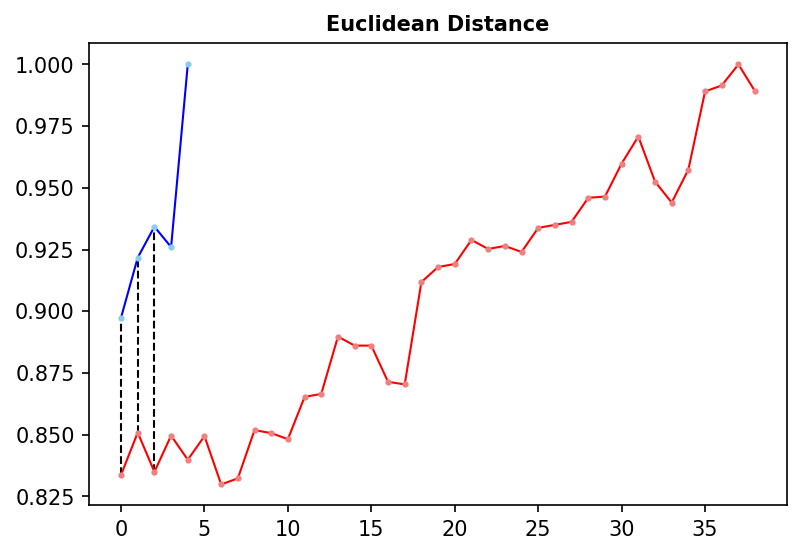

In [49]:
# Correlation between mdb and series_median_hh_inc
x = np.array(series_mdb_scaled)
y = np.array(series_median_hh_inc_scaled)

fig, ax = plt.subplots(figsize=(6, 4))

xx = [(i, x[i]) for i in np.arange(0, len(x))]
yy = [(j, y[j]) for j in np.arange(0, len(y))]

for i, j in zip(xx, yy[:-2]):
    ax.plot([i[0], j[0]], [i[1], j[1]], '--k', linewidth=1)

ax.plot(x, '-ro', label='x', linewidth=1, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
ax.plot(y, '-bo', label='y', linewidth=1, markersize=2, markerfacecolor='skyblue', markeredgecolor='skyblue')
ax.set_title("Euclidean Distance", fontsize=10, fontweight="bold")

In [50]:
x = series_mdb_scaled
y = series_median_hh_inc_scaled
x = pd.DataFrame(x)
y = pd.DataFrame(y)
dtw_distance, warp_path = fastdtw(x, y, dist=euclidean)
x = series_mdb_scaled
y = series_bb_scaled
cost_matrix = compute_accumulated_cost_matrix(x, y)

DTW distance:  0.9597300572259053
Warp path:  [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 2), (26, 2), (27, 2), (28, 2), (29, 2), (30, 2), (31, 2), (32, 2), (33, 2), (34, 3), (35, 4), (36, 4), (37, 4), (38, 4)]


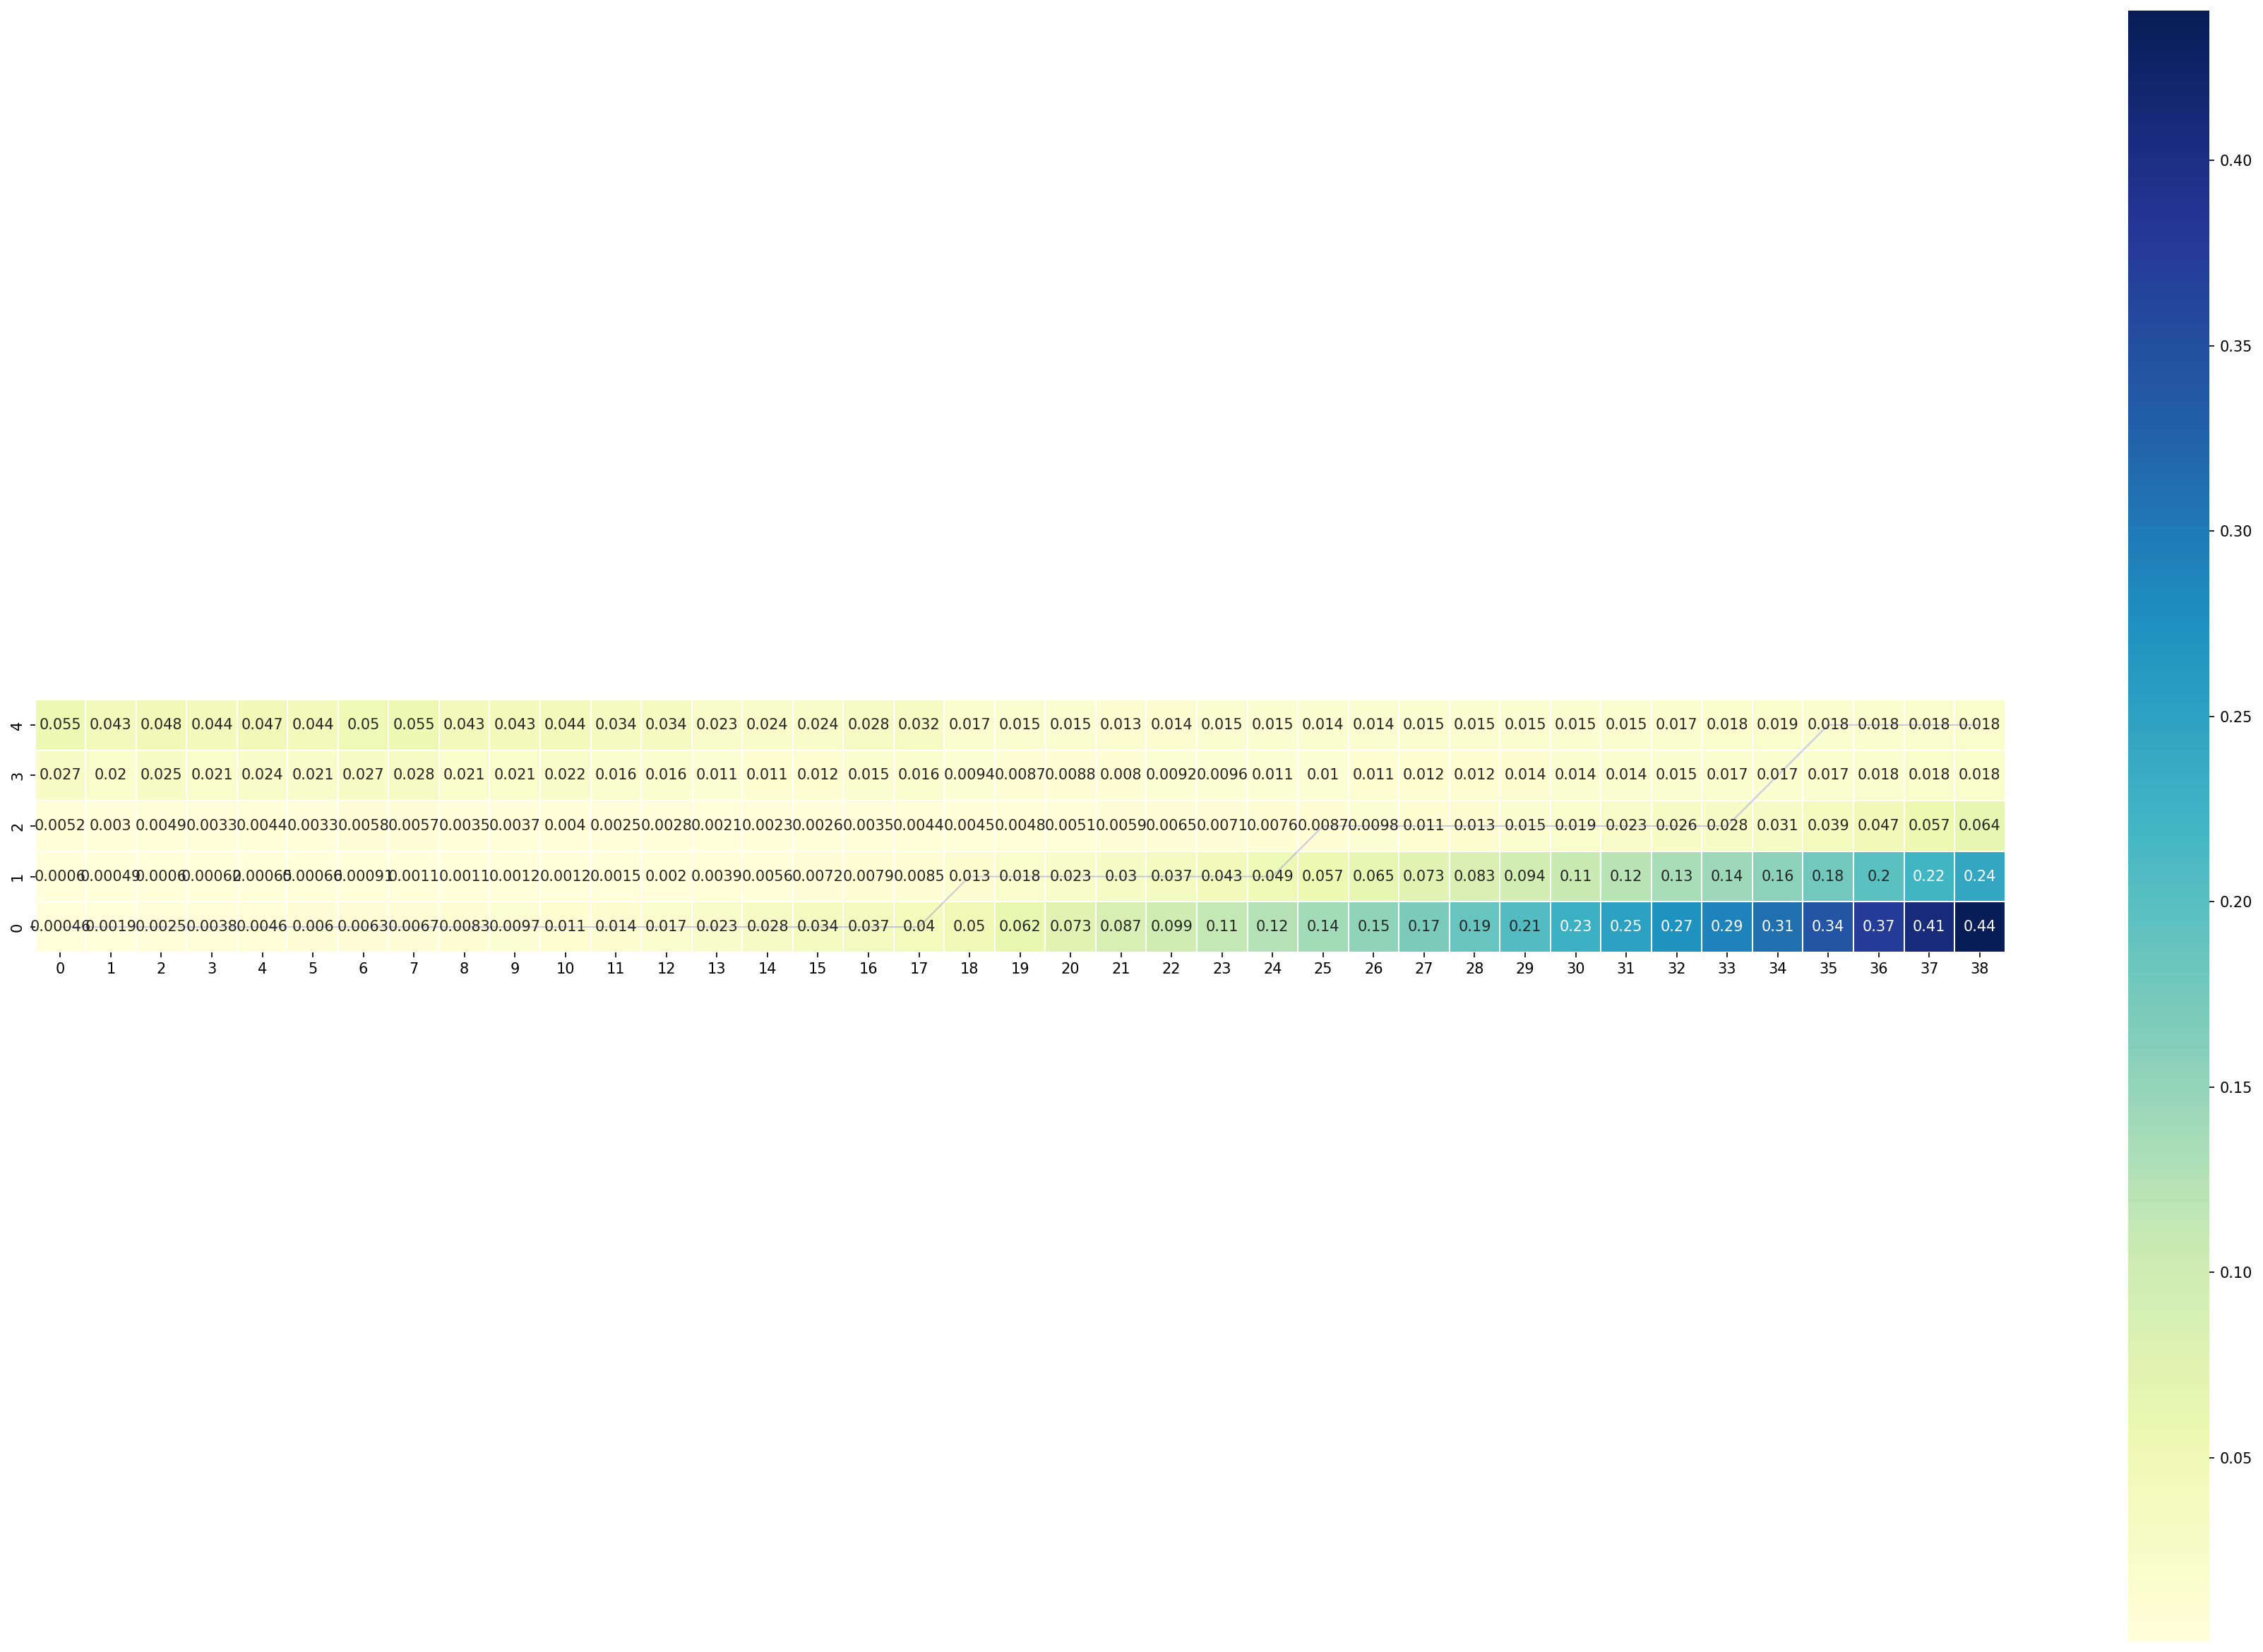

In [51]:
fig, ax = plt.subplots(figsize=(30, 20))
ax = sbn.heatmap(cost_matrix, annot=True, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)
ax.invert_yaxis()

# Get the warp path in x and y directions
path_x = [p[0] for p in warp_path]
path_y = [p[1] for p in warp_path]

# Align the path from the center of each cell
path_xx = [x+0.5 for x in path_x]
path_yy = [y+0.5 for y in path_y]

ax.plot(path_xx, path_yy, color='blue', linewidth=1, alpha=0.2)

print("DTW distance: ", dtw_distance)
print("Warp path: ", warp_path)